In [22]:
import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

In [23]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.01

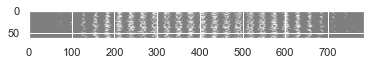

In [25]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [26]:
class FCNClass(nn.Module):
    def __init__(self):
        # input: 784 Dimensional Vectors as input
        super(FCNClass, self).__init__()

        # layer 1 (784-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden1 = nn.Sequential(
                        nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 2 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden2 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 3 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden3 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 4 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.output = nn.Sequential(
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )
        # 10 softmax activated output neurons
        self.outputLayer = nn.Softmax(dim=1)


    def forward(self, x):
        midLevel = self.hidden1(x)
        midLevel = self.hidden2(midLevel)
        midLevel = self.hidden3(midLevel)
        output   = self.output(midLevel)
        return output


In [27]:
model = FCNClass().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
opt = "SGD"

In [28]:
epochs = []
n_total_steps = len(train_loader)
train_loss_average = torch.zeros(num_epochs)
valid_loss_average = torch.zeros(num_epochs)
train_accuracy = torch.zeros(num_epochs)
valid_accuracy = torch.zeros(num_epochs)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,120], gamma=0.1)


In [29]:

def train():

    model.train()
    running_train_loss = 0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        train_step_loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        train_step_loss.backward()
        optimizer.step()

        running_train_loss += train_step_loss.item()

        #predictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100.*correct/total

    #get the training losses and accuracies
    train_loss_average[epoch] = running_train_loss/len(train_loader)
    train_accuracy[epoch] = accuracy

    print(f'Training Loss: {running_train_loss/len(train_loader)}\t \
            Training accuracy: {train_accuracy[epoch]}')


In [30]:
def test():
    model.eval()

    running_valid_loss = 0
    correct = 0
    total = 0

    #validation loop
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            valid_step_loss = criterion(outputs, labels)

            running_valid_loss += valid_step_loss.item()

            #predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.*correct/total

    #get the validation losses
    valid_loss_average[epoch] = running_valid_loss/len(test_loader)
    valid_accuracy[epoch] = accuracy


    print(f'Validation Loss: {running_valid_loss/len(test_loader)}\t \
            Validation accuracy: {valid_accuracy[epoch]}\t \
            LR:{curr_lr}')

In [31]:
start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    train()
    test()

    epochs.append(epoch)

    #get the current learning rate
    curr_lr = optimizer.param_groups[0]['lr']

    #step the learning rate scheduler
    scheduler.step()


print("--- %s seconds ---" % (time.time() - start_time))
print('Finished Training')


Epoch: 1
Training Loss: 2.2954619840772423	             Training accuracy: 12.15333366394043
Validation Loss: 2.2688001690396837	             Validation accuracy: 23.239999771118164	             LR:0.01
Epoch: 2
Training Loss: 2.2327251103895307	             Training accuracy: 16.503334045410156
Validation Loss: 2.104059442593034	             Validation accuracy: 28.06999969482422	             LR:0.01
Epoch: 3
Training Loss: 2.150232907678527	             Training accuracy: 20.171667098999023
Validation Loss: 1.9862406595497375	             Validation accuracy: 34.52000045776367	             LR:0.01
Epoch: 4
Training Loss: 2.086975287653998	             Training accuracy: 24.020000457763672
Validation Loss: 1.8757962876824057	             Validation accuracy: 47.88999938964844	             LR:0.01
Epoch: 5
Training Loss: 2.0247276059345904	             Training accuracy: 26.54166603088379
Validation Loss: 1.7518572845276754	             Validation accuracy: 47.81999969482422	          

In [32]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')



Accuracy of the network on the 10000 test images: 57.5 %


In [33]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(title + '.png')

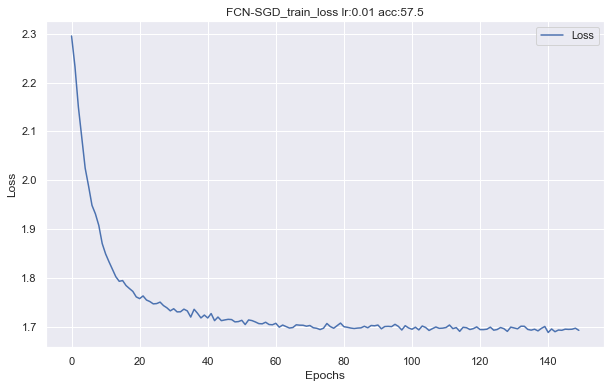

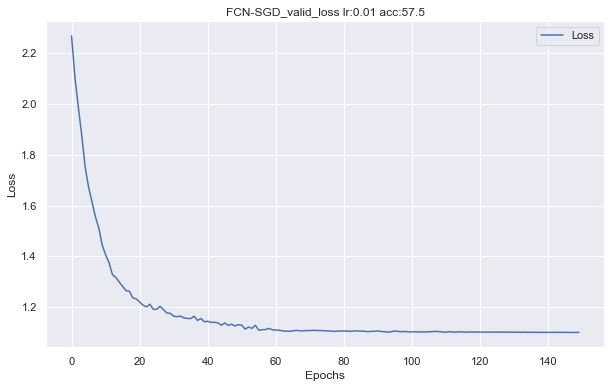

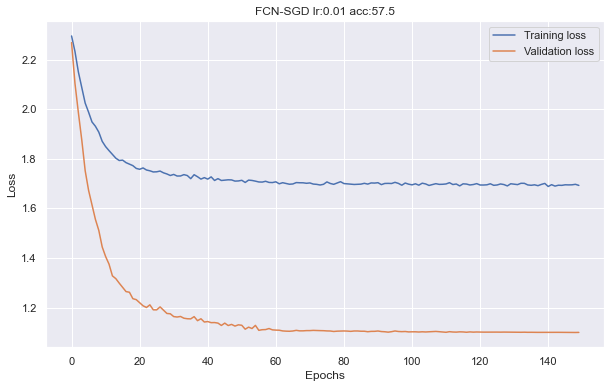

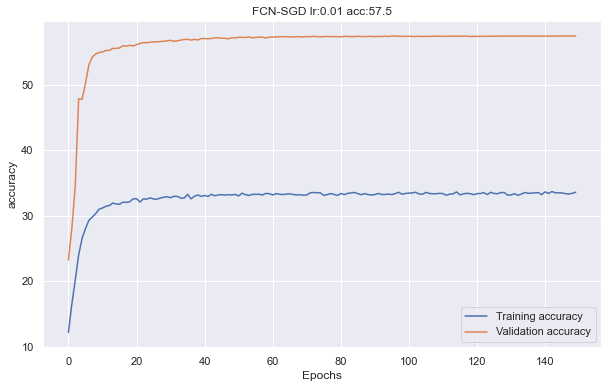

In [34]:
#plot the loss diagrams
plotLosses(epochs, train_loss_average, f'FCN-{opt}_train_loss lr:{learning_rate} acc:{acc}')
plotLosses(epochs, valid_loss_average, f'FCN-{opt}_valid_loss lr:{learning_rate} acc:{acc}')

#plot combo loss diagrams
plt.figure(figsize=(10,6))
plt.title(f'FCN-{opt} lr:{learning_rate} acc:{acc}')
plt.plot(epochs, train_loss_average, label = "Training loss")
plt.plot(epochs, valid_loss_average, label = 'Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(f'FCN-Loss-{opt} lr:{learning_rate} acc:{acc}.png')

#plot validation accuracies
plt.figure(figsize=(10,6))
plt.title(f'FCN-{opt} lr:{learning_rate} acc:{acc}')
plt.plot(epochs, train_accuracy, label = "Training accuracy")
plt.plot(epochs, valid_accuracy, label = 'Validation accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.savefig(f'FCN-Accuracy-{opt} lr:{learning_rate} acc:{acc}.png')

PATH = f'./FCN-{opt}-lr:{learning_rate}-acc:{acc}.pth'
torch.save(model.state_dict(), PATH)